In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import glob
import seaborn as sns
import itertools

In [2]:
def make_fc_frame(pipeline_dir, atlas_dir):
    fc = {}
    for file in glob.glob(f'../../data/scratch_roi_timeseries/_scan*/{pipeline_dir}/{atlas_dir}/*.csv'):
        run_name = file.split('/')[4]

        # make correlation matrix from roi timeseries file
        run_cor_mat = np.corrcoef(np.loadtxt(file, delimiter = ',').T)

        # upper triangle without diagonal
        upper_triangle = run_cor_mat[np.triu_indices_from(run_cor_mat, k=1)]
        fc[run_name] = upper_triangle 
    out = pd.DataFrame(fc)
    return(out)

In [3]:
def calc_split_half_similarity(d):
    df_list = []
    first_half = d[['_scan_movie_run-1', '_scan_movie_run-2', '_scan_movie_run-3', '_scan_movie_run-4']]
    second_half = d[['_scan_movie_run-5', '_scan_movie_run-6', '_scan_movie_run-7', '_scan_movie_run-8']]
    
    templates = [first_half.mean(axis = 1), second_half.mean(axis = 1)]
    for template_ind in [0,1]:
        for scans in [1,2,3,4]:
            combs = itertools.combinations([1,2,3,4], scans)
            cor_vals = []
            for i in list(combs):
                inds = np.array(i) - 1
                if template_ind == 0:
                    df_slice = second_half.iloc[:, inds]
                else:
                    df_slice = first_half.iloc[:, inds]
                df_slice_mean = df_slice.mean(axis = 1)
                cor_vals.append(np.corrcoef(df_slice_mean, templates[template_ind])[0,1])
                temp = pd.DataFrame({'similarity': cor_vals})
                temp['scans'] = scans
                temp['template'] = template_ind
                df_list.append(temp)
                
    # merge dataframes            
    similarity_merged = pd.concat(df_list)
    return(similarity_merged)

In [4]:
check_1 = make_fc_frame(pipeline_dir = '_selector_WM-2mmE-M_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_G-M_M-SDB_P-2_BP-B0.009-T0.08',
             atlas_dir = '_mask_CorticalAreaParcellationfromRestingStateCorrelationsGordon2014_mask_file_..ndmg_atlases..label..Human..CorticalAreaParcellationfromRestingStateCorrelationsGordon2014.nii.gz')

In [210]:
multi_list = []
fc_list = []
for atlas_path in glob.glob('../../data/scratch_roi_timeseries/_scan_movie_run-5/_selector_WM-2mmE-M_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_G-M_M-SDB_P-2_BP-B0.009-T0.08/_mask*'):
    for pipeline_path in glob.glob('../../data/scratch_roi_timeseries/_scan_movie_run-1/*'):
        pipeline = (pipeline_path.split('/')[5])
        atlas = atlas_path.split('/')[6]
        fc_df = make_fc_frame(pipeline, atlas)
        sim_df = calc_split_half_similarity(fc_df)
        sim_df['pipeline'] = pipeline
        sim_df['atlas'] = atlas
        fc_df['pipeline'] = pipeline
        fc_df ['atlas'] = atlas
        fc_list.append(fc_df)
        multi_list.append(sim_df)

In [187]:
multi_merge = pd.concat(multi_list)

In [204]:
multi_merge['despiking'] = multi_merge.pipeline.str.contains('FD-')
multi_merge.replace({'_mask_CorticalAreaParcellationfromRestingStateCorrelationsGordon2014_mask_file_..ndmg_atlases..label..Human..CorticalAreaParcellationfromRestingStateCorrelationsGordon2014.nii.gz': 'Gordon2014',
                     '_mask_Schaefer2018-200-node_space-MNI152NLin6_res-1x1x1_mask_file_..ndmg_atlases..label..Human..Schaefer2018-200-node_space-MNI152NLin6_res-1x1x1.nii.gz': 'Schafer-200',
                     '_mask_Schaefer2018-300-node_space-MNI152NLin6_res-1x1x1_mask_file_..ndmg_atlases..label..Human..Schaefer2018-300-node_space-MNI152NLin6_res-1x1x1.nii.gz': 'Schafer-300',
                     '_mask_Schaefer2018-400-node_space-MNI152NLin6_res-1x1x1_mask_file_..ndmg_atlases..label..Human..Schaefer2018-400-node_space-MNI152NLin6_res-1x1x1.nii.gz': 'Schafer-400',
                     '_mask_Schaefer2018-1000-node_space-MNI152NLin6_res-1x1x1_mask_file_..ndmg_atlases..label..Human..Schaefer2018-1000-node_space-MNI152NLin6_res-1x1x1.nii.gz': 'Schafer-1000'}, inplace = True)

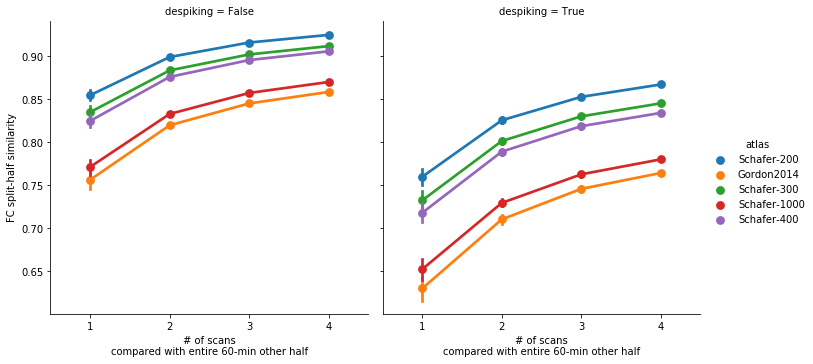

In [233]:
g =sns.catplot(x="scans", y="similarity",
                hue="atlas", col = 'despiking', kind = 'point',
                data=multi_merge)

g.set_axis_labels('# of scans\ncompared with entire 60-min other half', "FC split-half similarity")